In [1]:
from collections import defaultdict
import numpy as np
import random as rd
import copy
import networkx
import matplotlib.pyplot as plt

In [2]:
def make_graph_matrices(num_vertices):
    rd.seed(1)
    edges = []
    vertices = list(range(num_vertices))
    # Initialize adjacency matrix
    def init_adjacency_matrix(nodes, edges):
        adjacency_matrix = np.zeros((nodes,nodes),dtype = np.int)
        edge_probability = .085
        edges_cnt = 0
        for i in range(nodes):
            for j in range(i):
                prob = rd.random()
                if prob < edge_probability:
                    adjacency_matrix[i,j] = 1
                    edges.append((i,j))
                    edges_cnt += 1
        return adjacency_matrix, edges
    adjacency_matrix, edges = init_adjacency_matrix(num_vertices, edges)
    G=networkx.Graph()
    G.add_nodes_from(list(range(num_vertices)))
    G.add_edges_from(edges)
    adjacency_list = networkx.to_dict_of_lists(G)
    return adjacency_list,adjacency_matrix, edges, G

In [3]:
def calc_prob(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices):
    probs = {} #keys -> probs; vals -> connected vertices
    sumprob = 0
    for j in range(len(possible_vertices)): #sum of all the paths the ant can take ( denominator )
        temp_connected_vertex = possible_vertices[j] #one of the connected vertices
        vertex_degree = len(set(adj_list[temp_connected_vertex]) - set(ant.history_vertices))
        sumprob += ((phermone_dict[temp_connected_vertex]*(vertex_degree)**alpha)/weight_dict[temp_connected_vertex]) 
    
    for j in range(len(possible_vertices)): #probability for each path
        temp_connected_vertex = possible_vertices[j] #one of the connected vertices
        vertex_degree = len(set(adj_list[temp_connected_vertex]) - set(ant.history_vertices))
        probs_key = ((phermone_dict[temp_connected_vertex]*(vertex_degree)**alpha)/weight_dict[temp_connected_vertex])/sumprob
        
        if probs_key not in probs:
            probs[probs_key] = [temp_connected_vertex]
        else:
            probs[probs_key].append(temp_connected_vertex)

    probs = dict(sorted(probs.items(), key=lambda item: item[0]))
    return probs

In [4]:
class Ant:
    def __init__(self, number) -> None:
        self.number = number
        self.history_vertices = []
        self.last_visited = {}

    def __str__(self):
        return f"Ant {self.number}"

    def add_to_visited(self, end_vertex):
        self.history_vertices.append(end_vertex)
        self.last_visited = end_vertex
        
    def status(self):
        print(f"self.number: {self.number}")
        print(f"self.history_vertices: {self.history_vertices}")
        print(f"self.last_visited: {self.last_visited}")
        return

    def get_path_len(self):
        path_length = len(self.history_vertices)
        return self.number, path_length -1

In [5]:
def initialize(num_vertices, num_ants):
    adj_list, adj_mat, edges, G = make_graph_matrices(num_vertices) #Adjacency list of the n-hypercube graph
    return num_vertices, num_ants, adj_list, adj_mat, edges, G

In [6]:
def select_choice_vertex(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices):
    probs = calc_prob(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices)
    random_num = rd.random()
    cumsum_probs = dict(zip(np.cumsum(np.multiply(list(probs.keys()), [len(i) for i in probs.values()])), list(probs.values())))
    for prob in cumsum_probs:
        if random_num < prob:
            return rd.choice(cumsum_probs[prob])

In [7]:
def find_possible_vertices(ant, adj_list, no_visit_vertices):
    possible_vertices = set(adj_list) - set(ant.history_vertices)
    possible_vertices -= no_visit_vertices
    return list(possible_vertices)

In [8]:
def edges_covered(ant_edges):
    for ant,val in ant_edges:
        if not val:
            return True

In [9]:
def no_edge_vertices(adj_mat):
    ans = set()
    for vertex,row in enumerate(adj_mat):
        if sum(row) == 0:
            ans.add(vertex)
    return ans

In [10]:
def run_ants_on_hypercube_random_colors_optimized(n, num_ants, iterations): #  returns ((ant.number, path_length), iter)
    alpha = 2
    q_0 = 0.5
    num_vertices, num_ants, adj_list, adj_mat, edges, G = initialize(n, num_ants)
    pheromone_dict = {i:0.1 for i in range(num_vertices)}
    weight_dict = {i:1 for i in range(num_vertices)}
    evaporation_rate = 0.001
    iter = 0
    no_visit_vertices = no_edge_vertices(adj_mat)
    all_solutions = []
    #initialize ants 
    ants_list = [Ant(i) for i in range(num_ants)]
    
    #The fun begins
    while iter < iterations:
        print("iteration: ", iter)
        return_ants_list = []
        ant_edges = {i:copy.deepcopy(edges) for i in range(num_ants)}
        
        for ant in ants_list:
            ant.history_vertices = []
        local_pheromone_dict = defaultdict(float)
        
        for ant_number in range(num_ants):
            print(f"Ant: {ant_number}")
            curr_ant = ants_list[ant_number]
            if curr_ant in return_ants_list:
                continue
            if not ant_edges[ant_number]:
                return_ants_list.append(curr_ant)
                all_solutions.append(curr_ant.history_vertices)
                continue
            
            while len(ant_edges[ant_number]) > 0:
                possible_vertices = find_possible_vertices(curr_ant, adj_list, no_visit_vertices)
                if len(possible_vertices) == 0: 
                    print(ant_edges[ant_number], curr_ant.history_vertices)
                    print(f"Ant: {ant_number} is out of vertices to go to")
                    continue

                else:
                    choice_vertex = select_choice_vertex(curr_ant, adj_list, pheromone_dict, weight_dict, alpha, q_0, possible_vertices)
                
                curr_ant.add_to_visited(choice_vertex)
                local_pheromone_dict[choice_vertex] += 1/weight_dict[choice_vertex]
                ant_edges[ant_number] = [edge for edge in ant_edges[ant_number] if choice_vertex not in edge]
            if not ant_edges[ant_number]:
                    print("wtf 2")
                    return_ants_list.append(curr_ant)
                    all_solutions.append(curr_ant.history_vertices)
                    continue
        
        for vertex in local_pheromone_dict:
            pheromone_dict[vertex] = (1-evaporation_rate)*pheromone_dict[vertex] + local_pheromone_dict[vertex]
        
        iter += 1
    
    return return_ants_list, G, weight_dict, all_solutions


In [11]:
ants_list, G, vertex_weights, all_solutions = run_ants_on_hypercube_random_colors_optimized(100, 10, 50)

iteration:  0
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
iteration:  1
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
iteration:  2
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
iteration:  3
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
iteration:  4
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
iteration:  5
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
iteration:  6
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 

In [12]:
# print(all_solutions)

In [15]:
[len(solution) for solution in all_solutions]

[82,
 84,
 83,
 84,
 82,
 84,
 84,
 82,
 82,
 84,
 84,
 84,
 85,
 80,
 81,
 83,
 79,
 83,
 83,
 82,
 86,
 81,
 82,
 84,
 79,
 81,
 81,
 84,
 80,
 82,
 82,
 80,
 79,
 82,
 83,
 82,
 80,
 81,
 79,
 83,
 82,
 83,
 79,
 80,
 80,
 82,
 82,
 82,
 80,
 81,
 80,
 79,
 83,
 81,
 77,
 82,
 82,
 82,
 81,
 80,
 80,
 83,
 85,
 81,
 81,
 80,
 80,
 79,
 80,
 78,
 81,
 81,
 80,
 81,
 82,
 82,
 83,
 82,
 83,
 79,
 81,
 83,
 79,
 81,
 84,
 82,
 80,
 80,
 80,
 80,
 83,
 80,
 79,
 81,
 81,
 82,
 81,
 81,
 80,
 81,
 80,
 83,
 81,
 82,
 81,
 81,
 80,
 79,
 81,
 79,
 81,
 85,
 80,
 78,
 81,
 82,
 82,
 78,
 79,
 81,
 80,
 82,
 80,
 81,
 81,
 81,
 84,
 82,
 81,
 82,
 82,
 83,
 81,
 81,
 82,
 79,
 79,
 84,
 81,
 80,
 80,
 85,
 81,
 81,
 83,
 80,
 80,
 81,
 81,
 82,
 79,
 80,
 81,
 79,
 80,
 80,
 80,
 83,
 79,
 82,
 81,
 81,
 80,
 80,
 81,
 80,
 80,
 79,
 80,
 81,
 82,
 80,
 83,
 79,
 82,
 79,
 81,
 81,
 81,
 83,
 80,
 80,
 83,
 81,
 80,
 82,
 80,
 82,
 82,
 80,
 82,
 81,
 81,
 80,
 80,
 79,
 83,
 82,
 82,
 78,


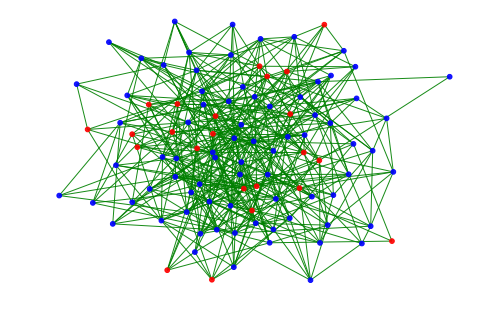

1.0
ACO: 77


In [16]:
color_map = []
min_num = 100000000000
solutions = []
for solution in all_solutions:
    if len(solution) < min_num:
        min_num = len(solution)
        solutions = solution
        
for node in G:
    if node in solutions:
        color_map.append('blue')
    else: 
        color_map.append('red')      

edge_colours = []
for (u,v) in G.edges():
    if u in solutions or v in solutions:
        edge_colours.append("green")
    else:
        edge_colours.append("red")
        
networkx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=22, alpha=0.9)
plt.show()

edges_visited = 0
for col in edge_colours:
    if col == "green":
        edges_visited+=1
print(edges_visited/len(edge_colours))
ant_cost = 0
for vertex in solutions:
    ant_cost += vertex_weights[vertex]
print(f"ACO: {ant_cost}")